# Test a linear regression model

In [77]:
from pathlib import Path
import os
import warnings

%load_ext autoreload
%autoreload 2

# ignore warnings for now ...
warnings.filterwarnings('ignore')

if Path('.').absolute().parents[1].name == 'ml_drought':
    os.chdir(Path('.').absolute().parents[1])

!pwd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jovyan/ml_drought


In [78]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch

from typing import List, Union, Optional, Tuple, Dict

data_dir = Path('data/')
# data_dir = Path('/Volumes/Lees_Extend/data/zip_data')
# data_dir = Path('/Volumes/Lees_Extend/data/ecmwf_sowc/data/')
# plot_dir = Path('/Users/tommylees/Downloads')

assert data_dir.exists()

In [79]:
import seaborn as sns
from src.utils import drop_nans_and_flatten

from src.analysis import read_train_data, read_test_data, read_pred_data

In [80]:
# EXPERIMENT =      'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
EXPERIMENT =      'one_month_forecast'
# TRUE_EXPERIMENT = 'ICLR_one_month_forecast_BOKU_boku_VCI_our_vars_ALL'
TRUE_EXPERIMENT = 'one_month_forecast'
TARGET_VAR =      'boku_VCI'

assert (data_dir / f'models/{EXPERIMENT}').exists()
assert (data_dir / f'models/{TRUE_EXPERIMENT}').exists()

print((data_dir / f'models/{EXPERIMENT}').as_posix())

data/models/one_month_forecast


# Read in the data

In [83]:
X_train, y_train = read_train_data(data_dir, experiment=TRUE_EXPERIMENT)
X_test, y_test = read_test_data(data_dir, experiment=TRUE_EXPERIMENT)
static_ds = xr.open_dataset(data_dir / "features/static_all/data.nc")

ds = xr.merge([y_train, y_test]).sortby('time').sortby('lat')
d_ = xr.merge([X_train, X_test]).sortby('time').sortby('lat')
ds = xr.merge([ds, d_])

In [84]:
print("TRAINING DATA")
display(ds)
print('\n\n')
print("TARGET DATA")
display(y_test)

TRAINING DATA


<xarray.Dataset>
Dimensions:     (lat: 45, lon: 35, time: 205)
Coordinates:
  * time        (time) datetime64[ns] 2001-12-31 2002-01-31 ... 2018-12-31
  * lat         (lat) float32 -5.0 -4.75 -4.5 -4.25 -4.0 ... 5.25 5.5 5.75 6.0
  * lon         (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
Data variables:
    boku_VCI    (time, lat, lon) float64 100.0 100.0 98.82 ... 11.94 78.34 40.51
    VCI3M       (time, lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    modis_ndvi  (time, lat, lon) float64 0.688 0.5456 0.7328 ... nan nan nan
    VCI         (time, lat, lon) float64 57.69 89.55 63.82 45.12 ... nan nan nan
    precip      (time, lat, lon) float64 102.0 107.6 122.3 111.1 ... nan nan nan
    E           (time, lat, lon) float64 85.9 60.61 60.61 57.43 ... nan nan nan
    Eb          (time, lat, lon) float64 3.518 1.266 1.266 2.995 ... nan nan nan
    SMroot      (time, lat, lon) float64 0.2638 0.2245 0.2245 ... nan nan nan
    SMsurf      (time, lat, lon) float64 0.2978 0.2648 0.2648 ... nan nan nan
    p84.162     (time, lat, lon) float64 1.45e-05 -5.456e-05 ... nan nan
    pev         (time, lat, lon) float64 -0.005993 -0.006077 ... nan nan
    sp          (time, lat, lon) float64 8.862e+04 8.927e+04 ... nan nan
    t2m         (time, lat, lon) float64 297.5 298.4 297.4 296.2 ... nan nan nan
    tp          (time, lat, lon) float64 0.003657 0.00285 0.004386 ... nan nan




TARGET DATA


<xarray.Dataset>
Dimensions:   (lat: 45, lon: 35, time: 36)
Coordinates:
  * lat       (lat) float32 6.0 5.75 5.5 5.25 5.0 ... -4.0 -4.25 -4.5 -4.75 -5.0
  * lon       (lon) float32 33.75 34.0 34.25 34.5 ... 41.5 41.75 42.0 42.25
  * time      (time) datetime64[ns] 2016-01-31 2016-02-29 ... 2018-12-31
Data variables:
    boku_VCI  (time, lat, lon) float64 64.45 52.16 97.37 96.48 ... nan nan nan

In [85]:
from src.utils import get_ds_mask
mask = get_ds_mask(X_train.VCI)

ealstm_pred = read_pred_data('ealstm', data_dir, experiment=EXPERIMENT)[-1].where(~mask)

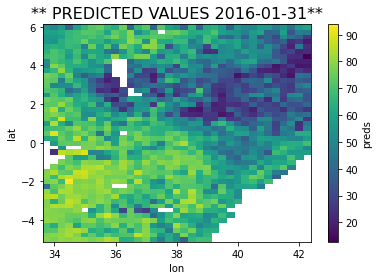

In [86]:
fig, ax = plt.subplots()
time_ix = 0
time = ealstm_pred.isel(time=time_ix).time.values
ealstm_pred.isel(time=time_ix).plot(ax=ax)
ax.set_title(f"** PREDICTED VALUES {str(time).split('T')[0]}**", size=16);

### Load in the models

In [87]:
from src.models import load_model

ealstm = load_model(data_dir / 'models' / EXPERIMENT / 'ealstm' / 'model.pt')
ealstm.models_dir = data_dir / 'models' / EXPERIMENT

ealstm.experiment = TRUE_EXPERIMENT
ealstm.features_per_month  # x.shape[-1] = the number of features in dynamic data 

16

# Errors

In [147]:
from src.analysis.evaluation import (r2_score, rmse, spatial_rmse, spatial_r2)

# load the static data

In [89]:
dl = ealstm.get_dataloader('train', batch_file_size=1, shuffle_data=False)
train_iter = iter(dl)
static_data = train_iter.static
print(f"N Vars: {len(list(static_data.data_vars))}")
static_data

FileNotFoundError: [Errno 2] No such file or directory: b'/home/jovyan/ml_drought/data/features/static/data.nc'

In [ ]:
global_vars = [v for v in static_data if 'global' in v]
pixel_vars = [v for v in static_data if 'pixel' in v]

fig, ax = plt.subplots()
static_data[global_vars[0]].plot(ax=ax)
fig, ax = plt.subplots()
static_data[pixel_vars[0]].plot(ax=ax)

# Play with Plots

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 8))

# d = ds.copy()
# d['season'] = d['time.season']
# d['precip'] = np.log(d['precip'] + 0.0001)
# d['target'] = d['boku_VCI'].shift(time=1)
# d.plot.scatter(x='precip', y='target', hue='season', ax=ax, alpha=0.5);

# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

### Return normalised data for the 

In [ ]:
# Regression of these variabls
d = X_train[['precip', 'pev', 'boku_VCI', 'SMsurf']].merge(y_train)

# normalise NON precip vals
for var in list(d.drop('precip').data_vars):
    d[var] = (d[var] - ealstm.normalizing_dict[var]['mean']) / ealstm.normalizing_dict[var]['std']
    
# log normalise precip vals
eps = 0.0001
p_mean = np.log(d['precip'] + eps).mean()
p_std = np.log(d['precip'] + eps).std()
d['precip'] = (np.log(d['precip'] + eps) - p_mean) / p_std

In [ ]:
# from mvstats.mvstats import linregress_ND
# cov, cor, slope, intercept, pval, stderr = linregress_ND(X, y)

In [98]:
# # to numpy

In [ ]:
def filter_nans(array1: np.ndarray, array2: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    """Filter nans in base numpy.
    
    for 2 arrays (first dimension is n_variables) mask each.
    """
    array1_shape = array1.shape
    array2_shape = array2.shape
    assert array1_shape[-1] == array2_shape[-1] 

    array1_nans = [np.isnan(array1[i, :]) for i in range(array1.shape[0])]
    array2_nans = [np.isnan(array2[i, :]) for i in range(array2.shape[0])]
    
    # which values in shape[-1]
    nan_arrays = np.any(array1_nans + array2_nans, axis=0)
    
    # create a mask of the same shape of array1/array2
    array1_mask = np.tile(nan_arrays, array1.shape[0]).reshape(-1, shape)
    array2_mask = np.tile(nan_arrays, array2.shape[0]).reshape(-1, shape)
    assert array1_mask.shape == array1.shape
    assert array2_mask.shape == array2.shape
    
    # use the mask to remove the nan values
    array1 = array1[~array1_mask].reshape(array1_shape[0], -1)
    array2 = array2[~array2_mask].reshape(array2_shape[0], -1)
    assert array1.shape[-1] == array2.shape[-1]
    
    # check all nans removed
    assert np.isnan(array1).mean() == 0
    assert np.isnan(array2).mean() == 0
    
    return array1, array2

# DROP NANS
numpy = False
if numpy:
    X = d[['precip', 'pev', 'SMsurf']]
    y = d['boku_VCI']

    X = X.to_array().values.reshape(3, -1)
    y = y.values.flatten().reshape(1, -1)

    assert y.shape[-1] == X.shape[-1]
    X_clean, y_clean = filter_nans(X, y)

# 

In [ ]:
X = d[['precip', 'pev', 'SMsurf']]
y = d['boku_VCI']

reg_df = xr.merge([X, y]).to_dataframe()

reg_df = reg_df.dropna(how='any')
reg_df

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
# cmap = sns.diverging_palette(int(220), int(10), as_cmap=True)
sns.heatmap(reg_df.corr(), ax=ax, cmap='RdBu_r', vmin=-1, vmax=1)
ax.set_title('Input Feature Correlations')
# sns.distplot(reg_df['precip'])

### Fit linear regression
- [Patsy Style formula](https://patsy.readthedocs.io/en/latest/) e.g. `y ~ X1 + X2`

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as fm_api

reg_df.columns

In [ ]:
est = sm.OLS(reg_df['boku_VCI'], reg_df.drop(columns=['boku_VCI']))

# Patsy style
# est = fm_api.ols(formula='boku_VCI ~ precip + pev + SMsurf', data=reg_df)
res = est.fit()

res.params

In [ ]:
pred_y = res.predict()
obs_y = reg_df['boku_VCI']
out_df = pd.DataFrame(dict(pred_y=pred_y, obs_y=obs_y), index=reg_df.index)
out_ds = out_df.to_xarray()

In [ ]:
fig, ax = plt.subplots()

plot_df = out_ds.isel(lat=slice(0, 100), lon=slice(0, 100)).to_dataframe()  # .plot.scatter(x='obs_y', y='pred_y', ax=ax, alpha=0.2, s='x', color='k');
sns.scatterplot(x='obs_y', y='pred_y', data=plot_df, ax=ax, alpha=0.2, markers='x', color='k')

ax.set_ylim(ax.get_xlim())
ax.set_title("How good are our predictions?")

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

### Plot for a single pixel

In [ ]:
out_df = out_df.reset_index()

In [ ]:
lat = out_df['lat'].unique()[0]
lon = out_df['lon'].unique()[0]

fig, ax = plt.subplots()
(
    out_df
    .query(f"lat == {lat} & lon == {lon}", inplace=False)
    .drop(columns=['lat','lon'])
    .set_index('time')
    .plot(ax=ax)
)

ax.set_title(f'lat={lat} lon={lon}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))

for lat, lon in zip(out_df['lat'].unique()[:10], out_df['lon'].unique()[:10]):
    try:
        (
            out_df
            .query(f"lat == {lat} & lon == {lon}", inplace=False)
            .drop(columns=['lat','lon', 'obs_y'])
            .set_index('time')
            .plot(ax=ax, label=f'lat={lat} lon={lon}')
        )
    except:
        pass

# ax.set_title()
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Does it differ sklearn SGDRegressor linear regression model?

In [180]:
from sklearn import linear_model

model_base = linear_model.SGDRegressor(
    early_stopping=True, tol=0.0001, validation_fraction=0.2, loss='squared_loss', penalty='none'
) 
model_elastic = linear_model.SGDRegressor(
    early_stopping=True, tol=0.0001, validation_fraction=0.2, loss='squared_loss', penalty='elasticnet'
) 
model_huber = linear_model.SGDRegressor(
    early_stopping=True, tol=0.0001, validation_fraction=0.2, loss='huber', penalty='none', epsilon=0.01,
) 
model_both = linear_model.SGDRegressor(
    early_stopping=True, tol=0.0001, validation_fraction=0.2, loss='huber', penalty='elasticnet', epsilon=0.01,
) 

models = {
    "Base": model_base,
    "Elastic": model_elastic,
    "Huber": model_huber,
    "Both": model_both,
}

In [181]:
model_base.epsilon

0.1

In [182]:
reg_df.head()

precip       pev    SMsurf  boku_VCI
lat lon   time                                              
6.0 33.75 2001-12-31 -0.172119 -0.855983  0.610596  0.011802
          2002-01-31 -0.721516 -0.905954  0.319781 -1.378617
          2002-02-28 -0.588918 -2.095744  0.062289 -0.307314
          2002-03-31  0.605821 -0.842167  0.705390  0.225473
          2002-04-30  0.374067 -1.330377  0.872311  0.393686

In [183]:
def model_predictions(model, target_var: str, data: pd.DataFrame) -> Union[pd.DataFrame, xr.Dataset]:
    """How does model perform predicting the training data?

    i.e. how good is the fit?
    """
    pred_y = model.predict(data.drop(columns=target_var))
    obs_y = data[target_var]
    out_df = pd.DataFrame(dict(pred_y=pred_y, obs_y=obs_y), index=data.index)
    out_ds = out_df.to_xarray()
    
    return out_ds


In [184]:
predicted = {}
for model_name, model in zip(models.keys(), models.values()):
    model.fit(reg_df.drop(columns=TARGET_VAR), reg_df[TARGET_VAR])
    out_ds = model_predictions(model, TARGET_VAR, data=reg_df)
    predicted[model_name] = out_ds.transpose('time', 'lat', 'lon')

In [185]:
scores = {}
for model_name, out_ds in zip(predicted.keys(), predicted.values()):
    rmse = spatial_rmse(out_ds['obs_y'], out_ds['pred_y'])
    r2 = spatial_r2(out_ds['obs_y'], out_ds['pred_y'])
    scores[model_name] = (rmse, r2)

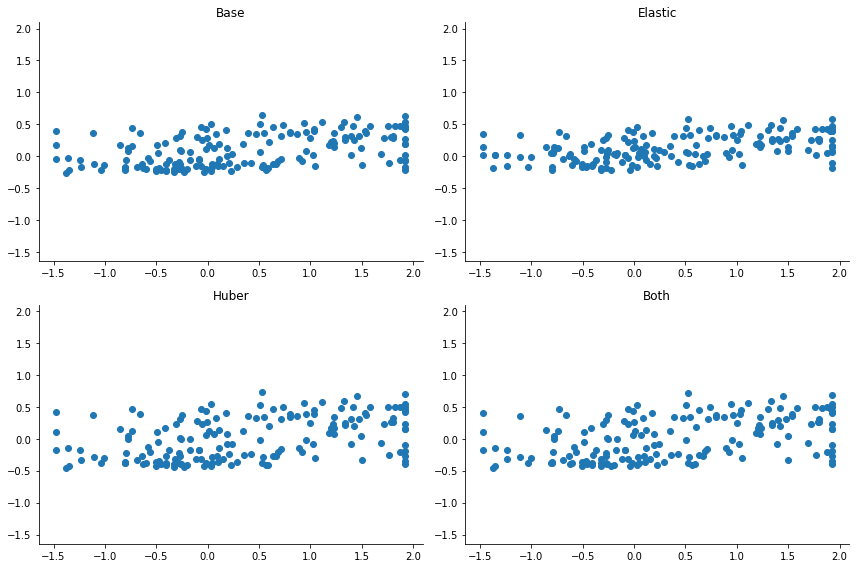

In [186]:
def plot_model_preds(out_ds, ax):
    ax.scatter(
        out_ds.obs_y.isel(lat=0, lon=0).values,
        out_ds.pred_y.isel(lat=0, lon=0).values,
    )
    ax.set_ylim(ax.get_xlim());

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

fig, axs = plt.subplots(2, 2, figsize=(6*2,4*2))

for ix, (model_name, out_ds) in enumerate(zip(predicted.keys(), predicted.values())):
    ax = axs[np.unravel_index(ix, (2, 2))]
    plot_model_preds(out_ds, ax)
    ax.set_title(model_name)
    
fig.tight_layout()

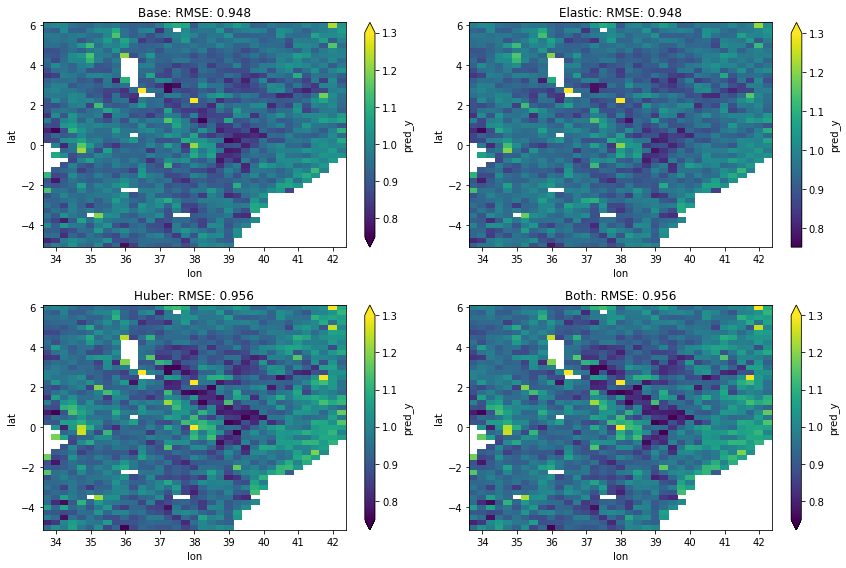

In [187]:
fig, axs = plt.subplots(2, 2, figsize=(6*2,4*2))

for ix, (model_name, score) in enumerate(zip(scores.keys(), scores.values())):
    ax = axs[np.unravel_index(ix, (2, 2))]
    score[0].plot(ax=ax, vmin=0.75, vmax=1.3)
    ax.set_title(f"{model_name}: RMSE: {score[0].mean().values:.3f}")
    
fig.tight_layout()